# Deep Q-Learning 

Install dependencies for AI gym to run properly (shouldn't take more than a minute). If running on google cloud or running locally, only need to run once. Colab may require installing everytime the vm shuts down.

In [1]:
!git clone https://github.com/EeshaR/cs444.git

Cloning into 'cs444'...
remote: Enumerating objects: 345, done.
remote: Counting objects: 100% (202/202), done.
remote: Compressing objects: 100% (202/202), done.
remote: Total 345 (delta 94), reused 0 (delta 0), pack-reused 143
Receiving objects: 100% (345/345), 21.29 MiB | 12.83 MiB/s, done.
Resolving deltas: 100% (141/141), done.


In [2]:
!pip3 install gym pyvirtualdisplay
!sudo apt-get install -y xvfb python-opengl ffmpeg

Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:4.2.7-0ubuntu0.1).
xvfb is already the newest version (2:1.20.13-1ubuntu1~20.04.17).
The following additional packages will be installed:
  freeglut3 libglu1-mesa libpython2-stdlib libpython2.7-minimal
  libpython2.7-stdlib python2 python2-minimal python2.7 python2.7-minimal
Suggested packages:
  python-tk python-numpy libgle3 python2-doc python2.7-doc binfmt-support
The following NEW packages will be installed:
  freeglut3 libglu1-mesa libpython2-stdlib libpython2.7-minimal
  libpython2.7-stdlib python-opengl python2 python2-minimal python2.7
  python2.7-minimal
0 upgraded, 10 newly installed, 0 to remove and 65 not upgraded.
Need to get 4540 kB of archives.
After this operation, 22.7 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal-updates/universe amd64 libpython2.7-minimal amd64 2.7.18-1~20.04.4 [335 kB]
Get:2 

In [3]:
!pip3 install --upgrade setuptools --user
!pip3 install ez_setup 
!pip3 install gym[atari] 
!pip3 install gym[accept-rom-license] 

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 894.6/894.6 kB 15.4 MB/s eta 0:00:00a 0:00:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.2.1 which is incompatible.
  Preparing metadata (setup.py) ... done
  Created wheel for ez_setup: filename=ez_setup-0.9-py3-none-any.whl size=10995 sha256=96666f0f8249010aa9cbf0bfc6444ac6e7857dcb16ca8c6511edafdab71691f6
  Stored in directory: /root/.cache/pip/wheels/7a/d6/77/8f495e85fb7df23d41c328b9ea3cf0d9e83631b20bba479293
Successfully built ez_setup
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 24.4 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 9.2 MB/s eta 0:00:0000:01
  Installing build dependencies ... done
  Getting requiremen

For this assignment we will implement the Deep Q-Learning algorithm with Experience Replay as described in breakthrough paper __"Playing Atari with Deep Reinforcement Learning"__. We will train an agent to play the famous game of __Breakout__.

In [4]:
%matplotlib inline
import sys

# Add the path to the directory containing the `gan` package to sys.path
sys.path.append('/kaggle/working/cs444/assignment5')

import sys
import gym
import torch
import pylab
import random
import numpy as np
from collections import deque
from datetime import datetime
from copy import deepcopy
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from utils import find_max_lives, check_live, get_frame, get_init_state
from model import DQN, DQN_LSTM
from config import *

import matplotlib.pyplot as plt
# %load_ext autoreload
# %autoreload 2

## Understanding the environment

In the following cell, we initialize our game of __Breakout__ and you can see how the environment looks like. For further documentation of the of the environment refer to https://gym.openai.com/envs. 

In breakout, we will use 3 actions "fire", "left", and "right". "fire" is only used to reset the game when a life is lost, "left" moves the agent left and "right" moves the agent right.

In [5]:
env = gym.make('BreakoutDeterministic-v4')
state = env.reset()

A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]


In [6]:
number_lives = find_max_lives(env)
state_size = env.observation_space.shape
action_size = 3 #fire, left, and right

/opt/conda/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


## Creating a DQN Agent

Here we create a DQN Agent. This agent is defined in the __agent.py__. The corresponding neural network is defined in the __model.py__. Once you've created a working DQN agent, use the code in agent.py to create a double DQN agent in __agent_double.py__. Set the flag "double_dqn" to True to train the double DQN agent.

__Evaluation Reward__ : The average reward received in the past 100 episodes/games.

__Frame__ : Number of frames processed in total.

__Memory Size__ : The current size of the replay memory.

In [7]:
double_dqn = False # set to True if using double DQN agent

if double_dqn:
    from agent_double import Agent
else:
    from agent import Agent

agent = Agent(action_size)
evaluation_reward = deque(maxlen=evaluation_reward_length)
frame = 0
memory_size = 0

### Main Training Loop

In this training loop, we do not render the screen because it slows down training signficantly. To watch the agent play the game, run the code in next section "Visualize Agent Performance"

episode: 0   score: 4.0   memory length: 295   epsilon: 1.0    steps: 295    lr: 0.0001     evaluation reward: 4.0
episode: 1   score: 3.0   memory length: 560   epsilon: 1.0    steps: 265    lr: 0.0001     evaluation reward: 3.5
episode: 2   score: 2.0   memory length: 758   epsilon: 1.0    steps: 198    lr: 0.0001     evaluation reward: 3.0
episode: 3   score: 0.0   memory length: 881   epsilon: 1.0    steps: 123    lr: 0.0001     evaluation reward: 2.25
episode: 4   score: 0.0   memory length: 1004   epsilon: 1.0    steps: 123    lr: 0.0001     evaluation reward: 1.8
episode: 5   score: 2.0   memory length: 1225   epsilon: 1.0    steps: 221    lr: 0.0001     evaluation reward: 1.8333333333333333
episode: 6   score: 2.0   memory length: 1422   epsilon: 1.0    steps: 197    lr: 0.0001     evaluation reward: 1.8571428571428572
episode: 7   score: 0.0   memory length: 1545   epsilon: 1.0    steps: 123    lr: 0.0001     evaluation reward: 1.625
episode: 8   score: 1.0   memory length: 17

KeyboardInterrupt: 

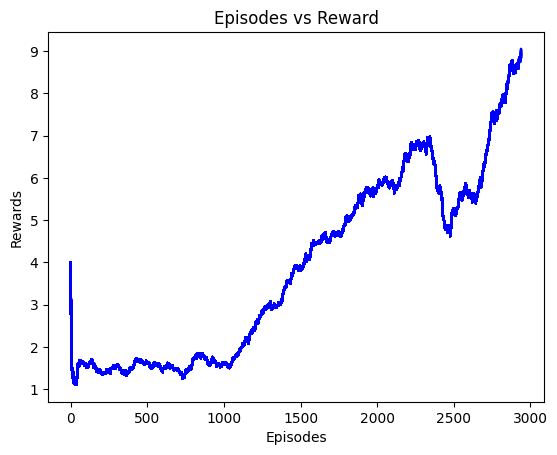

In [8]:
import os

# Create the directory for saving graphs if it does not exist
if not os.path.exists("./save_graph"):
    os.makedirs("./save_graph")
    
if not os.path.exists("./save_model"):
    os.makedirs("./save_model")

rewards, episodes = [], []
best_eval_reward = 0

for e in range(EPISODES):
    done = False
    score = 0

    history = np.zeros([5, 84, 84], dtype=np.uint8)
    step = 0
    state, _ = env.reset()
    next_state = state
    life = number_lives

    get_init_state(history, state, HISTORY_SIZE)

    while not done:
        step += 1
        frame += 1

        # Perform a fire action if ball is no longer on screen to continue onto next life
        if step > 1 and len(np.unique(next_state[:189] == state[:189])) < 2:
            action = torch.tensor([[0]]).cuda()
        else:
            action = agent.get_action(np.float32(history[:4, :, :]) / 255.)
        state = next_state
        
        # next_state, reward, done, _, info = env.step(action + 1)
        next_state, reward, terminated, truncated, info = env.step(action + 1)
        done = terminated or truncated

        frame_next_state = get_frame(next_state)
        history[4, :, :] = frame_next_state
        terminal_state = check_live(life, info['lives'])

        life = info['lives']
        r = reward

        # Store the transition in memory 
        agent.memory.push(deepcopy(frame_next_state), action.cpu(), r, terminal_state)
        # Start training after random sample generation
        if(frame >= train_frame): # You can set train_frame to a lower value while testing your starts training earlier
            agent.train_policy_net(frame)
            # Update the target network only for Double DQN only
            if double_dqn and (frame % update_target_network_frequency)== 0:
                agent.update_target_net()
        score += reward
        history[:4, :, :] = history[1:, :, :]
            
        if done:
            evaluation_reward.append(score)
            rewards.append(np.mean(evaluation_reward))
            episodes.append(e)
            pylab.plot(episodes, rewards, 'b')
            pylab.xlabel('Episodes')
            pylab.ylabel('Rewards') 
            pylab.title('Episodes vs Reward')
            pylab.savefig("./save_graph/breakout_dqn.png") # save graph for training visualization
            
            # every episode, plot the play time
            print("episode:", e, "  score:", score, "  memory length:",
                  len(agent.memory), "  epsilon:", agent.epsilon, "   steps:", step,
                  "   lr:", agent.optimizer.param_groups[0]['lr'], "    evaluation reward:", np.mean(evaluation_reward))

            # if the mean of scores of last 100 episode is bigger than 5 save model
            ### Change this save condition to whatever you prefer ###
            if np.mean(evaluation_reward) > 5 and np.mean(evaluation_reward) > best_eval_reward:
                torch.save(agent.policy_net, "./save_model/breakout_dqn.pth")
                best_eval_reward = np.mean(evaluation_reward)

# Visualize Agent Performance

BE AWARE THIS CODE BELOW MAY CRASH THE KERNEL IF YOU RUN THE SAME CELL TWICE.

Please save your model before running this portion of the code.

In [10]:
torch.save(agent.policy_net, "./save_model/breakout_dqn_latest.pth")

In [14]:
# from gym.wrappers import Monitor # If importing monitor raises issues, try using `from gym.wrappers import RecordVideo`
from gym.wrappers import RecordVideo
import glob
import io
import base64

from IPython.display import HTML
from IPython import display as ipythondisplay

from pyvirtualdisplay import Display

# Displaying the game live
def show_state(env, step=0, info=""):
    plt.figure(3)
    plt.clf()
    plt.imshow(env.render(mode='rgb_array'))
    plt.title("%s | Step: %d %s" % ("Agent Playing",step, info))
    plt.axis('off')

    ipythondisplay.clear_output(wait=True)
    ipythondisplay.display(plt.gcf())
    
# Recording the game and replaying the game afterwards
def show_video():
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else: 
        print("Could not find video")
    

def wrap_env(env):
    env = RecordVideo(env, './video', force=True)
    return env

In [15]:
display = Display(visible=0, size=(300, 200))
display.start()

# Load agent
# agent.load_policy_net("./save_model/breakout_dqn.pth")
agent.epsilon = 0.0 # Set agent to only exploit the best action

env = gym.make('BreakoutDeterministic-v4')
env = wrap_env(env)

done = False
score = 0
step = 0
state = env.reset()
next_state = state
life = number_lives
history = np.zeros([5, 84, 84], dtype=np.uint8)
get_init_state(history, state)

while not done:
    
    # Render breakout
    env.render()
#     show_state(env,step) # uncommenting this provides another way to visualize the game

    step += 1
    frame += 1

    # Perform a fire action if ball is no longer on screen
    if step > 1 and len(np.unique(next_state[:189] == state[:189])) < 2:
        action = 0
    else:
        action = agent.get_action(np.float32(history[:4, :, :]) / 255.)
    state = next_state
    
    next_state, reward, done, info = env.step(action + 1)
        
    frame_next_state = get_frame(next_state)
    history[4, :, :] = frame_next_state
    terminal_state = check_live(life, info['ale.lives'])
        
    life = info['ale.lives']
    r = np.clip(reward, -1, 1) 
    r = reward

    # Store the transition in memory 
    agent.memory.push(deepcopy(frame_next_state), action, r, terminal_state)
    # Start training after random sample generation
    score += reward
    
    history[:4, :, :] = history[1:, :, :]
env.close()
show_video()
display.stop()

Exception ignored in: <function RecordVideo.__del__ at 0x78c51c1a0700>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/gym/core.py", line 241, in __getattr__
    return getattr(self.env, name)
  File "/opt/conda/lib/python3.10/site-packages/gym/core.py", line 241, in __getattr__
    return getattr(self.env, name)
  File "/opt/conda/lib/python3.10/site-packages/gym/core.py", line 241, in __getattr__
    return getattr(self.env, name)
  [Previous line repeated 996 more times]
  File "/opt/conda/lib/python3.10/site-packages/gym/core.py", line 239, in __getattr__
    if name.startswith("_"):
RecursionError: maximum recursion depth exceeded while calling a Python object


TypeError: RecordVideo.__init__() got an unexpected keyword argument 'force'